In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import math
import tensorflow
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler 
from sklearn.metrics import mean_squared_error
import seaborn as sns
import pickle

In [2]:
data = pd.read_csv('Brinjal.csv')

In [3]:
#Drop na's.
data.dropna(axis=0, inplace=True) #remove all rows with na's.
data.reset_index(drop=True)

,date,centre_name,commodity_name,price
0,2001-01-09,DELHI,Brinjal,20
1,2001-01-09,MUMBAI,Brinjal,22
2,2001-01-10,DELHI,Brinjal,17
3,2001-01-13,DELHI,Brinjal,23
4,2001-01-13,MUMBAI,Brinjal,27
...,...,...,...,...
1248,2015-12-09,DELHI,Brinjal,18
1249,2015-12-09,MUMBAI,Brinjal,26
1250,2015-12-10,DELHI,Brinjal,20
1251,2015-12-11,DELHI,Brinjal,18


In [4]:
#calculate average price for each centre for each day 
data_gp = data.sort_values('date').groupby(['centre_name', 'date'], as_index=False)
data_gp = data_gp.agg({'price':['mean']})
data_gp.columns = ['centre_name', 'date', 'price']
data_gp.head()

,centre_name,date,price
0,DELHI,2001-01-09,20
1,DELHI,2001-01-10,17
2,DELHI,2001-01-13,23
3,DELHI,2001-01-14,30
4,DELHI,2001-02-10,19


In [5]:
#centre_1_train_dataset
centre_1_data = data_gp.loc[(data_gp['centre_name']=="DELHI"),["price"]].values
centre_1_data = centre_1_data.astype("float32")

#centre_2_train_dataset
centre_2_data = data_gp.loc[(data_gp['centre_name']=="KOLKATA"),["price"]].values
centre_2_data = centre_2_data.astype("float32")

#centre_2_train_dataset
centre_3_data = data_gp.loc[(data_gp['centre_name']=="MUMBAI"),["price"]].values
centre_3_data = centre_3_data.astype("float32")

print(centre_1_data.size,centre_2_data.size,centre_3_data.size)

631 177 445


In [6]:
#take last year as test dataset
train_centre_1 = centre_1_data[:-365]
test_centre_1 = centre_1_data[-365:]

train_centre_2 = centre_2_data[:-365]
test_centre_2 = centre_2_data[-365:]

train_centre_3 = centre_3_data[:-365]
test_centre_3 = centre_3_data[-365:]

print("train size: {}, test size: {}".format(len(train_centre_1), len(test_centre_1)))

train size: 266, test size: 365


In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

#transform the data using minmax scaler
scaler_2 = MinMaxScaler(feature_range=(0,1))
scaler_3 = MinMaxScaler(feature_range=(0,1))

train_centre_1 = scaler.fit_transform(train_centre_1)
test_centre_1 = scaler.transform(test_centre_1)

# train_centre_2 = scaler_2.fit_transform(train_centre_2)
# test_centre_2 = scaler_2.transform(test_centre_2)

train_centre_3 = scaler_3.fit_transform(train_centre_3)
test_centre_3 = scaler_3.transform(test_centre_3)

In [8]:
#train:

time_step = 30
datax_centre_1=[]
datay_centre_1=[]

for i in range(len(train_centre_1)-time_step-1):
    datax_centre_1.append(train_centre_1[i:(i+time_step),0])
    datay_centre_1.append(train_centre_1[i+time_step,0])
trainx_centre_1=np.array(datax_centre_1)
trainy_centre_1=np.array(datay_centre_1)

datax_centre_2=[]
datay_centre_2=[]

for i in range(len(train_centre_2)-time_step-1):
    datax_centre_2.append(train_centre_2[i:(i+time_step),0])
    datay_centre_2.append(train_centre_2[i+time_step,0])
trainx_centre_2=np.array(datax_centre_2)
trainy_centre_2=np.array(datay_centre_2)

datax_centre_3=[]
datay_centre_3=[]

for i in range(len(train_centre_3)-time_step-1):
    datax_centre_3.append(train_centre_3[i:(i+time_step),0])
    datay_centre_3.append(train_centre_3[i+time_step,0])
trainx_centre_3=np.array(datax_centre_3)
trainy_centre_3=np.array(datay_centre_3)

In [9]:
#test:

datax_centre_1=[]
datay_centre_1=[]

for i in range(len(test_centre_1)-time_step-1):
    datax_centre_1.append(test_centre_1[i:(i+time_step),0])
    datay_centre_1.append(test_centre_1[i+time_step,0])
testx_centre_1=np.array(datax_centre_1)
testy_centre_1=np.array(datay_centre_1)


datax_centre_2=[]
datay_centre_2=[]

for i in range(len(test_centre_2)-time_step-1):
    datax_centre_2.append(test_centre_2[i:(i+time_step),0])
    datay_centre_2.append(test_centre_2[i+time_step,0])
testx_centre_2=np.array(datax_centre_2)
testy_centre_2=np.array(datay_centre_2)

datax_centre_3=[]
datay_centre_3=[]

for i in range(len(test_centre_3)-time_step-1):
    datax_centre_3.append(test_centre_3[i:(i+time_step),0])
    datay_centre_3.append(test_centre_3[i+time_step,0])
testx_centre_3=np.array(datax_centre_3)
testy_centre_3=np.array(datay_centre_3)

In [10]:
trainx_centre_1=np.reshape(trainx_centre_1, (trainx_centre_1.shape[0],1,trainx_centre_1.shape[1]))
testx_centre_1=np.reshape(testx_centre_1, (testx_centre_1.shape[0],1,testx_centre_1.shape[1]))

# trainx_centre_2=np.reshape(trainx_centre_2, (trainx_centre_2.shape[0],1,trainx_centre_2.shape[1]))
# testx_centre_2=np.reshape(testx_centre_2, (testx_centre_2.shape[0],1,testx_centre_2.shape[1]))

trainx_centre_3=np.reshape(trainx_centre_3, (trainx_centre_3.shape[0],1,trainx_centre_3.shape[1]))
testx_centre_3=np.reshape(testx_centre_3, (testx_centre_3.shape[0],1,testx_centre_3.shape[1]))


In [11]:
model =Sequential()
model.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_1 = model.fit(trainx_centre_1, trainy_centre_1, epochs=100, batch_size=32,    validation_split=0.1, shuffle=False)

Epoch 1/100
7/7 [==============================] - 0s 54ms/step - loss: 1.0135 - val_loss: 1.1445
Epoch 2/100
7/7 [==============================] - 0s 5ms/step - loss: 0.9784 - val_loss: 1.1269
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 0.9520 - val_loss: 1.1110
Epoch 4/100
7/7 [==============================] - 0s 6ms/step - loss: 0.9281 - val_loss: 1.0966
Epoch 5/100
7/7 [==============================] - 0s 6ms/step - loss: 0.9060 - val_loss: 1.0835
Epoch 6/100
7/7 [==============================] - 0s 5ms/step - loss: 0.8852 - val_loss: 1.0717
Epoch 7/100
7/7 [==============================] - 0s 5ms/step - loss: 0.8657 - val_loss: 1.0608
Epoch 8/100
7/7 [==============================] - 0s 5ms/step - loss: 0.8472 - val_loss: 1.0508
Epoch 9/100
7/7 [==============================] - 0s 5ms/step - loss: 0.8294 - val_loss: 1.0417
Epoch 10/100
7/7 [==============================] - 0s 6ms/step - loss: 0.8124 - val_loss: 1.0332
Epoch 11/100
7/7 [==========

In [12]:
# model_2 =Sequential()
# model_2.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
# model_2.add(Dense(1))
# model_2.compile(loss='mean_squared_error', optimizer='adam')
# history_2 = model.fit(trainx_centre_2, trainy_centre_2, epochs=100, batch_size=32,   validation_split=0.1, shuffle=False)

In [13]:
model_3 =Sequential()
model_3.add(LSTM(20, input_shape=(1, time_step))) #20 LSTM neuron
model_3.add(Dense(1))
model_3.compile(loss='mean_squared_error', optimizer='adam')
history_3 = model.fit(trainx_centre_3, trainy_centre_3, epochs=100, batch_size=32,  validation_split=0.1, shuffle=False) 

Epoch 1/100
2/2 [==============================] - 0s 63ms/step - loss: 0.7745 - val_loss: 0.5115
Epoch 2/100
2/2 [==============================] - 0s 18ms/step - loss: 0.6641 - val_loss: 0.3501
Epoch 3/100
2/2 [==============================] - 0s 14ms/step - loss: 0.4981 - val_loss: 0.1918
Epoch 4/100
2/2 [==============================] - 0s 13ms/step - loss: 0.3362 - val_loss: 0.0766
Epoch 5/100
2/2 [==============================] - 0s 13ms/step - loss: 0.2129 - val_loss: 0.0185
Epoch 6/100
2/2 [==============================] - 0s 13ms/step - loss: 0.1397 - val_loss: 0.0115
Epoch 7/100
2/2 [==============================] - 0s 13ms/step - loss: 0.1115 - val_loss: 0.0383
Epoch 8/100
2/2 [==============================] - 0s 13ms/step - loss: 0.1139 - val_loss: 0.0785
Epoch 9/100
2/2 [==============================] - 0s 13ms/step - loss: 0.1307 - val_loss: 0.1152
Epoch 10/100
2/2 [==============================] - 0s 12ms/step - loss: 0.1482 - val_loss: 0.1380
Epoch 11/100
2/2 [=

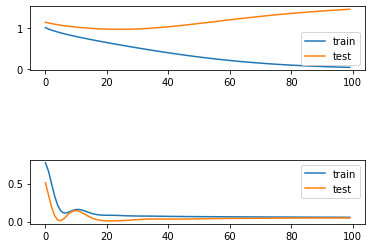

In [14]:
fig = plt.figure()
plt.subplot(3, 1, 1)
plt.plot(history_1.history['loss'], label='train')
plt.plot(history_1.history['val_loss'], label='test')
plt.legend();

# plt.subplot(3, 1, 2)
# plt.plot(history_2.history['loss'], label='train')
# plt.plot(history_2.history['val_loss'], label='test')
# plt.legend();

plt.subplot(3, 1, 3)
plt.plot(history_3.history['loss'], label='train')
plt.plot(history_3.history['val_loss'], label='test')
plt.legend();

In [15]:
trainy_centre_1 = trainy_centre_1.reshape(1,-1)
testy_centre_1 = testy_centre_1.reshape(1,-1)

# trainy_centre_2 = trainy_centre_2.reshape(1,-1)
# testy_centre_2 = testy_centre_2.reshape(1,-1)

trainy_centre_3 = trainy_centre_3.reshape(1,-1)
testy_centre_3 = testy_centre_3.reshape(1,-1)

In [16]:
testPredict_centre_1 = model.predict(testx_centre_1)
testPredict_centre_1 = scaler.inverse_transform(testPredict_centre_1)
testy_centre_1 = scaler.inverse_transform(testy_centre_1)
trainPredict_centre_1 = model.predict(trainx_centre_1)
trainPredict_centre_1 = scaler.inverse_transform(trainx_centre_1)
trainy_centre_1 = scaler.inverse_transform(trainy_centre_1)

# testPredict_centre_2 = model.predict(testx_centre_2)
# trainPredict_centre_2 = model.predict(trainx_centre_2)
# trainPredict_centre_2 = scaler.inverse_transform(trainx_centre_2)
# testPredict_centre_2 = scaler.inverse_transform(testPredict_centre_2)
# testy_centre_2 = scaler.inverse_transform(testy_centre_2)
# trainy_centre_2 = scaler.inverse_transform(trainy_centre_2)

testPredict_centre_3 = model.predict(testx_centre_3)
trainPredict_centre_3 = model.predict(trainx_centre_3)
trainPredict_centre_3 = scaler.inverse_transform(trainx_centre_3)
testPredict_centre_3 = scaler.inverse_transform(testPredict_centre_3)
testy_centre_3 = scaler.inverse_transform(testy_centre_3)
trainy_centre_3 = scaler.inverse_transform(trainy_centre_3)

<Figure size 432x288 with 0 Axes>

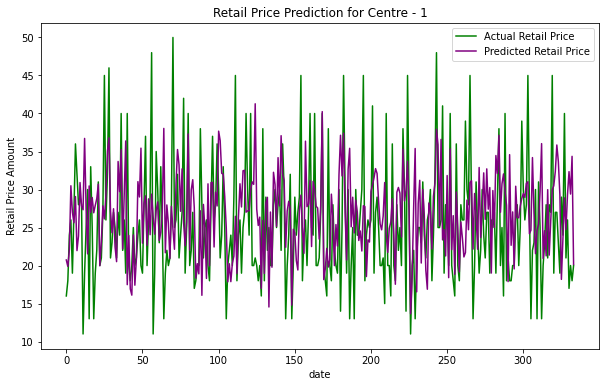

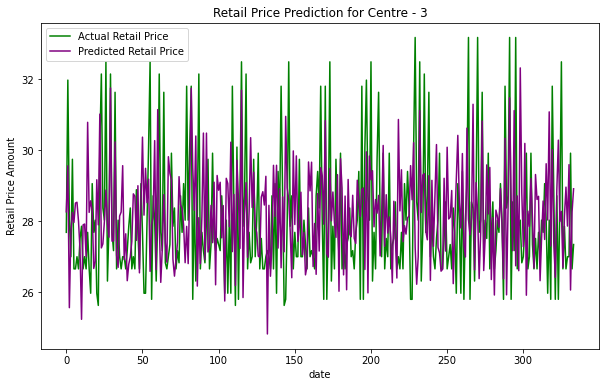

In [17]:
fig = plt.figure()
plt.figure(figsize=(10,6))
plt.plot(testy_centre_1[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_1 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 1')
plt.xlabel('date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

# plt.figure(figsize=(10,6))
# plt.plot(testy_centre_2[0], color='green', label='Actual Retail Price')
# plt.plot(testPredict_centre_2 , color='purple', label='Predicted Retail Price')
# plt.title('Retail Price Prediction for Centre - 2')
# plt.xlabel('date')
# plt.ylabel('Retail Price Amount')
# plt.legend()
# plt.show()

plt.figure(figsize=(10,6))
plt.plot(testy_centre_3[0], color='green', label='Actual Retail Price')
plt.plot(testPredict_centre_3 , color='purple', label='Predicted Retail Price')
plt.title('Retail Price Prediction for Centre - 3')
plt.xlabel('date')
plt.ylabel('Retail Price Amount')
plt.legend()
plt.show()

In [18]:
# trainscore = math.sqrt(mean_squared_error(trainy_centre_1[0], trainPredict_centre_1[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_1[0], testPredict_centre_1[:,0]))
# print("Train MSE: {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_1[0], trainPredict_centre_1[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_1[0], testPredict_centre_1[:,0]))
# print("Train MSE for centre 1 model : {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_2[0], trainPredict_centre_2[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_2[0], testPredict_centre_2[:,0]))
# print("Train MSE for centre 2 model : {}, Test MSE: {}".format(trainscore, testscore))

# trainscore = math.sqrt(mean_squared_error(trainy_centre_3[0], trainPredict_centre_3[:,0]))
# testscore = math.sqrt(mean_squared_error(testy_centre_3[0], testPredict_centre_3[:,0]))
# print("Train MSE for centre 3 model : {}, Test MSE: {}".format(trainscore, testscore))

In [19]:
print(trainy_centre_3[0], trainPredict_centre_3[:,0])

[26.65285  27.510174 26.30992  26.65285  28.881893 26.65285  26.30992
 28.710428 25.96699  29.739218 28.024569 29.396288 28.024569 25.62406
 25.795525 28.710428 33.168518 28.024569 28.710428 32.13973  26.65285
 27.681639 33.168518 27.338709 26.995779 26.65285  27.510174 27.510174
 26.65285  27.167244 26.30992  26.65285  28.881893 26.65285  26.30992
 29.739218 28.024569 31.282402 28.024569 25.62406  33.168518 25.795525
 29.053358 33.168518 26.30992  27.853104 28.710428 26.65285  26.824314] [[26.65285  27.510174 26.30992  ... 26.65285  27.510174 26.65285 ]
 [27.510174 26.30992  26.65285  ... 27.510174 26.65285  26.65285 ]
 [26.30992  26.65285  28.024569 ... 26.65285  26.65285  27.510174]
 ...
 [33.168518 28.024569 28.710428 ... 33.168518 26.30992  27.853104]
 [28.024569 28.710428 32.13973  ... 26.30992  27.853104 28.710428]
 [28.710428 32.13973  26.65285  ... 27.853104 28.710428 26.65285 ]]


# Predicting 90 days of 2015

In [20]:
#use retail price of last 30 days of 2014 to predict next 90 days

#centre-1
testPredict_centre_1 = []

x_data_centre_1 = testx_centre_1[-1] #get transformed retail price values of last 30 days 
x_centre_1 = np.reshape(x_data_centre_1,(1,1,30))
yhat = model.predict(x_centre_1)
testPredict_centre_1 = np.append(testPredict_centre_1,scaler.inverse_transform(yhat))
x_data_centre_1 = np.append(x_data_centre_1,yhat)

for i in range (89):
        x_data_centre_1 = x_data_centre_1[1:]
        x_centre_1 = np.reshape(x_data_centre_1,(1,1,30))
        yhat = model.predict(x_centre_1)
        testPredict_centre_1 = np.append(testPredict_centre_1,scaler.inverse_transform(yhat))
        x_data_centre_1 = np.append(x_data_centre_1,yhat)
        
# #centre-2     
# testPredict_centre_2 = []

# x_data_centre_2 = testx_centre_2[-1] #get transformed retail price values of last 30 days 
# x_centre_2 = np.reshape(x_data_centre_2,(1,1,30))
# yhat = model.predict(x_centre_2)
# testPredict_centre_2 = np.append(testPredict_centre_2,scaler.inverse_transform(yhat))
# x_data_centre_2 = np.append(x_data_centre_2,yhat)

# for i in range (89):
#         x_data_centre_2 = x_data_centre_2[1:]
#         x_centre_2 = np.reshape(x_data_centre_2,(1,1,30))
#         yhat = model.predict(x_centre_2)
#         testPredict_centre_2 = np.append(testPredict_centre_2,scaler.inverse_transform(yhat))
#         x_data_centre_2 = np.append(x_data_centre_2,yhat)
        
#centre-3
testPredict_centre_3 = []

x_data_centre_3 = testx_centre_3[-1] #get transformed retail price values of last 30 days 
x_centre_3 = np.reshape(x_data_centre_3,(1,1,30))
yhat = model.predict(x_centre_3)
testPredict_centre_3 = np.append(testPredict_centre_3,scaler.inverse_transform(yhat))
x_data_centre_3 = np.append(x_data_centre_3,yhat)

for i in range (89):
        x_data_centre_3 = x_data_centre_3[1:]
        x_centre_3 = np.reshape(x_data_centre_3,(1,1,30))
        yhat = model.predict(x_centre_3)
        testPredict_centre_3 = np.append(testPredict_centre_3,scaler.inverse_transform(yhat))
        x_data_centre_3 = np.append(x_data_centre_3,yhat)
        


In [21]:
#Create Dataframe with predicted retail prices
centre_1_test_df = pd.DataFrame(columns = ['date','centre_name', 'commodity_name', 'predicted_retail_price'])
centre_1_test_df['date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_1_test_df['centre_name'] = "DELHI"
centre_1_test_df['commodity_name'] = "Brinjal"
centre_1_test_df['predicted_retail_price'] = testPredict_centre_1

# #Create Dataframe with predicted retail prices
# centre_2_test_df = pd.DataFrame(columns = ['date','centre_name', 'commodity_name', 'Predicted_Retail_Price'])
# centre_2_test_df['date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
# centre_2_test_df['centre_name'] = "KOLKATA"
# centre_2_test_df['commodity_name'] = "Brinjal"
# centre_2_test_df['Predicted_Retail_Price'] = testPredict_centre_2

#Create Dataframe with predicted retail prices
centre_3_test_df = pd.DataFrame(columns = ['date','centre_name', 'commodity_name', 'predicted_retail_price'])
centre_3_test_df['date']=pd.date_range(start='1/1/2015' ,end = '31/3/2015', freq='D')
centre_3_test_df['centre_name'] = "MUMBAI"
centre_3_test_df['commodity_name'] = "Brinjal"
centre_3_test_df['predicted_retail_price'] = testPredict_centre_3

test_df = pd.concat([centre_1_test_df, centre_3_test_df],ignore_index=True)
test_df

,date,centre_name,commodity_name,predicted_retail_price
0,2015-01-01,DELHI,Brinjal,20.165276
1,2015-01-02,DELHI,Brinjal,17.998468
2,2015-01-03,DELHI,Brinjal,21.944881
3,2015-01-04,DELHI,Brinjal,21.234098
4,2015-01-05,DELHI,Brinjal,21.004030
...,...,...,...,...
175,2015-03-27,MUMBAI,Brinjal,27.729418
176,2015-03-28,MUMBAI,Brinjal,28.274693
177,2015-03-29,MUMBAI,Brinjal,29.811687
178,2015-03-30,MUMBAI,Brinjal,27.848425


In [22]:
test_df.to_csv('lstm_price_prediction_brinjal.csv',index=False)